In [138]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import cmocean
import os
import pyfilaments.analysisutils as analysis
from pyfilaments._def_analysis import *
import pandas as pd
import h5py

from joblib import Parallel, delayed
import multiprocessing
%matplotlib notebook
plt.close('all')

from tqdm import tqdm

save_folder = '/home/deepak/Dropbox/LacryModeling/processed_data/SearchDynamics'
# Create a folder for storing Publication figures
# Check which platform
if platform == "linux" or platform == "linux2":
    print("linux system")
    ROOT_PATH = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'

elif platform == 'darwin':
    print("OSX system")
    ROOT_PATH = '/Users/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'

publication_figures = os.path.join(ROOT_PATH,'Figure2')
import _figure_parameters

linux system


## Load data

In [139]:
# Lognormal activity, Lacry distribution 
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/Lognormal_distribution'

# Deterministic activity, Lacry distribution
data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/DistributedActivity_LacryType/NeckHead_scalefactor_2'

# Deterministic activity, Uniform distribution
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/DistributedActivitySims_2022_11_11'

# Deterministic activity , Point distribution
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23'

sim_folders = os.listdir(data_folder)

## Load the unique locations time-series data and assemble a dataframe

In [140]:
# Find all unique position time-series data 
n_time = 1000 # Number of time-points to interpolate the common time array

save_data = True
overwrite = True

data_file = 'UniqueLocsVisited_FullData_squarewave_lacry.csv'

save_file = os.path.join(save_folder, data_file)

if not os.path.exists(save_file) or overwrite==True:

    df_ensemble = pd.DataFrame({})  # Holds the data over all simulations

    for folder in sim_folders:
        # each sim_folder corresponds to a unique parameter set

        curr_folder = os.path.join(data_folder, folder)

        min_common_time = np.nan
        max_common_time = 0

        file_counter = 0

        time_array = {}
        unique_locs_array = {}
        analysis_file_array = {}

        sim_files = [file for file in os.listdir(curr_folder) if file.endswith('.hdf5')]

        for file in sim_files:

            # each .hdf5 file corresponds to a simulation run

            file_name = file[:-5]
            analysis_file = os.path.join('Analysis',file_name + '_analysis.csv')



            unique_pos_file = os.path.join('Analysis', 'SearchCoverage',file_name + '_unique_counts_timeseries.csv' )

            df_analysis = pd.read_csv(os.path.join(curr_folder, analysis_file))

            sim_complete = df_analysis['simulation completed'][0]

            if sim_complete:

                df_unique_pos = pd.read_csv(os.path.join(curr_folder, unique_pos_file))

                time = df_unique_pos['Time']

                min_common_time = min(np.max(time), min_common_time)

                max_common_time = max(np.min(time), max_common_time)

                time_array[file_counter] = time
                unique_locs_array[file_counter] = df_unique_pos['Unique positions count']

                analysis_file_array[file_counter] = analysis_file

                file_counter+=1


        if file_counter > 0:                
            # Create a common time-array

            print(file_counter)
            common_time_array = np.linspace(max_common_time, min_common_time, n_time)
            for ii in range(file_counter):

                time = time_array[ii]
                unique_locs = unique_locs_array[ii]

                analysis_file = analysis_file_array[ii]
                df_analysis = pd.read_csv(os.path.join(curr_folder, analysis_file))
                
                L = (df_analysis['N particles']-1)*df_analysis['bond length']
                theoretical_max_locs = int((L)**2)

                data_func = interpolate.interp1d(time, unique_locs, kind = 'linear')

                # Interpolate the data to a common time array
                unique_locs_sampled = data_func(common_time_array)
                

                # Save the interpolated data as well as other filament parameters in a new dataframe
                unique_locs_dict = {'Time':common_time_array, 'Initial condition': np.repeat(ii, n_time),
                                   'Unique positions count': unique_locs_sampled, 
                                    'Theoretical max locs':np.repeat(theoretical_max_locs, n_time)}
                
                filament_params_dict = {column:np.repeat(df_analysis[column][0], n_time) for column in df_analysis.columns}

                df_sampled = pd.DataFrame({**unique_locs_dict, **filament_params_dict})


                # Add this to the master data frame
                df_ensemble = pd.concat([df_ensemble, df_sampled], ignore_index=True)
    
    # 
    df_ensemble['Percent of max locs'] = 100*df_ensemble['Unique positions count']/df_ensemble['Theoretical max locs']
    
    if save_data:
        df_ensemble.to_csv(save_file)


else:
    print('Loading data from file ...')
    df_ensemble = pd.read_csv(save_file)


sim_type = np.unique(df_ensemble['simulation type'])
try:
    activity_type = np.unique(df_ensemble['activity type'])
except:
    activity_type = 'point'

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


In [104]:
df_ensemble['activity type']

0         square-wave
1         square-wave
2         square-wave
3         square-wave
4         square-wave
             ...     
306995    square-wave
306996    square-wave
306997    square-wave
306998    square-wave
306999    square-wave
Name: activity type, Length: 307000, dtype: object

<IPython.core.display.Javascript object>


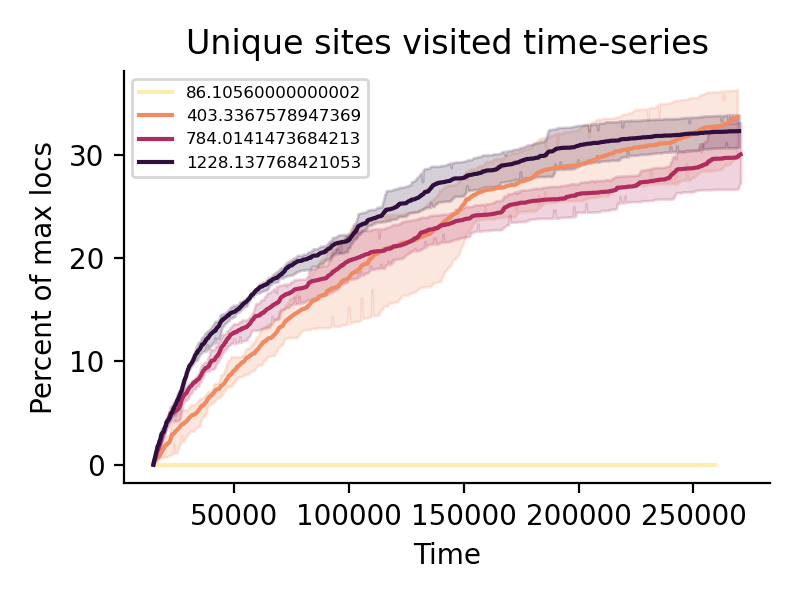

In [125]:
# Plot the unique locs sampled vs parameter

parameter = 'activity number'
y_data = 'Percent of max locs'
save = False

title = 'Unique sites visited time-series'
plt.figure(figsize=(4,3))

sns.lineplot(data = df_ensemble, x = 'Time', 
             y = y_data, hue = parameter, ci = 95, 
             palette = cmocean.cm.matter, legend = 'full')


plt.title(title)
plt.xlabel('Time')
# plt.yscale('log')
plt.legend(loc='best', prop={'size':6})
sns.despine(right=True, top=True)

plt.tight_layout()

if save:
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)

plt.show()

## For each parameter, fit the data to a Kinetic equation and store the results of the fit

In [141]:
# Aggregate and store the mean and std across different ICs of the same parameters

groupby_params = ['periodic dynamics','simulation type', 'activity type','activity number', 'potDipole strength', ' activity time scale','Time']

result = df_ensemble.groupby(groupby_params, as_index=False).agg({'Percent of max locs':['mean', 'std']})

print(result)

parameter = 'activity number'
parameter_values  = np.unique(result[parameter])

print(parameter_values)

      periodic dynamics simulation type activity type activity number  \
                                                                        
0                 False           lacry   square-wave      525.697347   
1                 False           lacry   square-wave      525.697347   
2                 False           lacry   square-wave      525.697347   
3                 False           lacry   square-wave      525.697347   
4                 False           lacry   square-wave      525.697347   
...                 ...             ...           ...             ...   
17995              True           lacry   square-wave     1291.584000   
17996              True           lacry   square-wave     1291.584000   
17997              True           lacry   square-wave     1291.584000   
17998              True           lacry   square-wave     1291.584000   
17999              True           lacry   square-wave     1291.584000   

      potDipole strength  activity time scale     

### Function for fitting

In [142]:
# Define the type of function we want to fit
import scipy.optimize as optimize

def f(t, N_max, Tau):
    """ Michelis-Mentin type function
    
        y = t*N_max/(t + Tau)
        
        
    """
    return N_max*t / (t + Tau)

In [143]:
save_data = True
overwrite = True

save_file = os.path.join(save_folder, 'SearchDynamicsFit_{}_{}.csv'.format(sim_type, activity_type))


if not os.path.exists(save_file) or overwrite:

    df_unique_locs_fit = pd.DataFrame({})

    for value in parameter_values:

        df_chunk = result.loc[result[parameter]== value]

        time_array = np.array(df_chunk['Time'])

        # rescale the time array to start at 0
        time_array = time_array[1:]-time_array[1]

        unique_locs_means = np.array(df_chunk['Percent of max locs']['mean'][1:])
        unique_locs_std = np.array(df_chunk['Percent of max locs']['std'][1:])


        if np.any(np.isnan(unique_locs_std)) or np.any(unique_locs_std==0):
            print('Not using standard errors')
            p_opt, p_cov = optimize.curve_fit(f, time_array, unique_locs_means,
                           bounds = [(0, 0), (np.inf, np.inf)])
        else:
            print('Using standard errors')
            p_opt, p_cov = optimize.curve_fit(f, time_array, unique_locs_means, sigma = unique_locs_std,
                       bounds = [(0, 0), (np.inf, np.inf)])

        perr = np.sqrt(np.diag(p_cov)) # Calculate error in the fit


        unique_locs_fit_dict = {parameter:[value],
                             'Saturation value fit':[p_opt[0]], 'Saturation value sigma':[perr[0]], 
                                'Saturation time fit':[p_opt[1]], 'Saturation time sigma':[perr[1]]}

        filament_params_dict = {key: np.array(df_chunk[key])[0] for key in groupby_params}

        df_unique_locs_fit = df_unique_locs_fit.append(pd.DataFrame({**unique_locs_fit_dict, **filament_params_dict}))


    if save_data:
        df_unique_locs_fit.to_csv(save_file)
    
else:
    
    print('Loading processed data from file ...')
    df_unique_locs_fit = pd.read_csv(save_file)
    
    
    
    
    
    
 

Not using standard errors
Not using standard errors
Not using standard errors
Not using standard errors
Not using standard errors
Not using standard errors
Not using standard errors
Using standard errors
Using standard errors
Not using standard errors
Not using standard errors
Not using standard errors
Not using standard errors
Using standard errors
Not using standard errors
Not using standard errors
Not using standard errors
Not using standard errors


In [108]:
df_unique_locs_fit

,activity number,Saturation value fit,Saturation value sigma,Saturation time fit,Saturation time sigma,periodic dynamics,simulation type,activity type,potDipole strength,activity time scale,Time
0,26.908000,0.033382,0.000089,3.399338e+03,143.612872,True,point,square-wave,0.500000,750,75000.0
0,30.357744,0.023596,0.000024,6.983671e-01,7.573649,True,point,square-wave,0.564103,750,75000.0
0,33.807487,0.023596,0.000024,6.983671e-01,7.573649,True,point,square-wave,0.628205,750,75000.0
0,37.257231,0.023596,0.000024,6.983671e-01,7.573649,True,point,square-wave,0.692308,750,75000.0
0,40.706974,0.047193,0.000048,4.498543e-01,7.564380,True,point,square-wave,0.756410,750,75000.0
0,44.156718,0.047193,0.000048,4.498543e-01,7.564380,True,point,square-wave,0.820513,750,75000.0
0,47.606462,0.047193,0.000048,4.498543e-01,7.564380,True,point,square-wave,0.884615,750,75000.0
0,51.056205,0.070788,0.000048,2.095727e-01,5.036943,True,point,square-wave,0.948718,750,75000.0
0,54.505949,0.094384,0.000048,1.837242e-08,3.773794,True,point,square-wave,1.012821,750,75000.0
0,57.955692,0.494267,0.000388,3.444605e+03,54.568454,False,point,square-wave,1.076923,750,75000.0


Time scale for rescaling: [750]


<IPython.core.display.Javascript object>


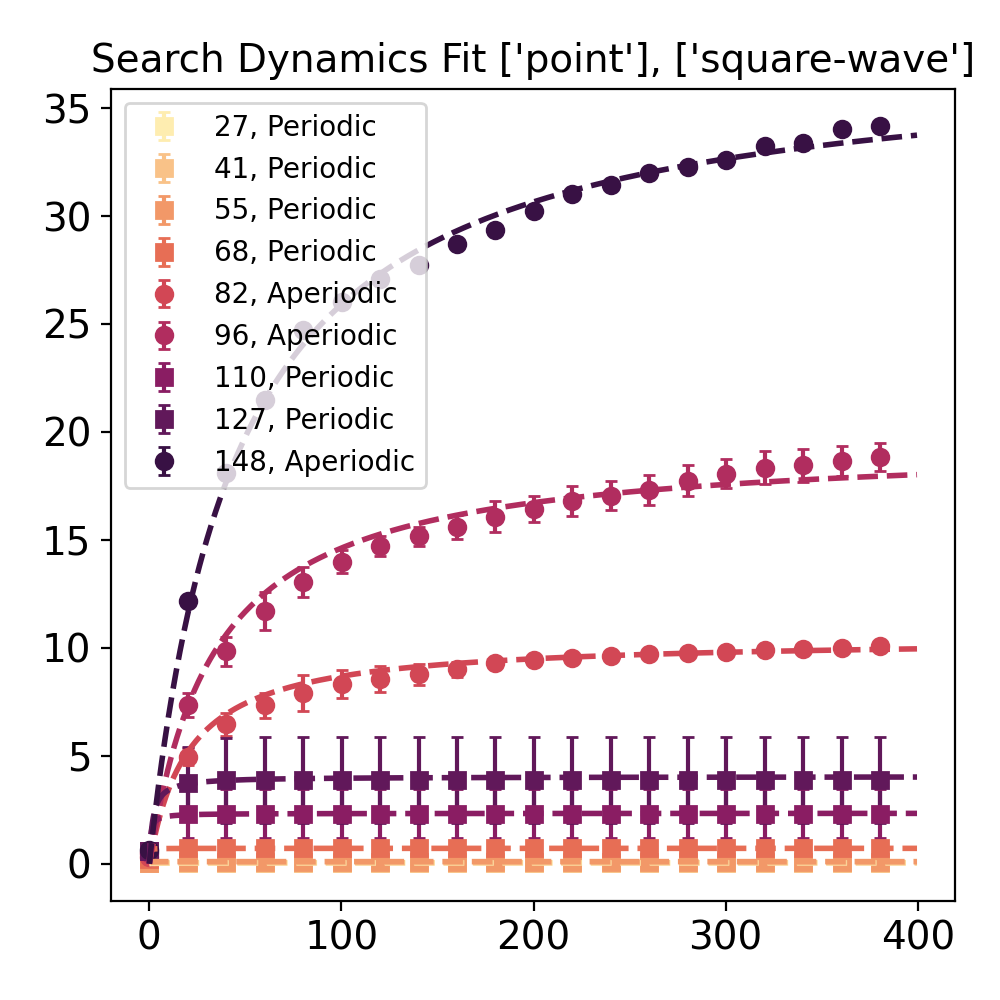

[ 26.908       40.70697436  54.50594872  68.30492308  82.10389744
  95.90287179 109.70184615 126.9505641  147.64902564]


/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [116]:
# Plot the simulation data and the results from the fit
categories = ['Periodic', 'Aperiodic']
markers = {'Periodic':'s', 'Aperiodic':'o'}


time_scale = np.unique(df_unique_locs_fit[' activity time scale'])

print('Time scale for rescaling: {}'.format(time_scale))

save_fig = True

plt.figure(figsize = (5,5))

title = 'Search Dynamics Fit {}, {}'.format(sim_type, activity_type)

cmap = cmocean.cm.matter
linear_array = np.linspace(0,1,len(parameter_values))
colors={}

for ii, cat in enumerate(parameter_values):

    colors[cat]=cmap(linear_array[ii])
    
parameter_values_to_plot = parameter_values[::4]
    
print(parameter_values_to_plot)

for value in parameter_values_to_plot:

    df_chunk = result.loc[result[parameter]== value]

    df_fit_chunk = df_unique_locs_fit[df_unique_locs_fit[parameter]==value]
            
    period = np.array(df_chunk['periodic dynamics'])[0]
    
    if period == True:
        period = 'Periodic'
    else:
        period = 'Aperiodic'
        
        
    time_array = np.array(df_chunk['Time'])

    # Rescale the time array to start at 0
    time_array = time_array[1:]-time_array[1]

    unique_locs_means = np.array(df_chunk['Percent of max locs']['mean'][1:])
    unique_locs_std = np.array(df_chunk['Percent of max locs']['std'][1:])

    # Load the values of the data fit
    n_max = df_fit_chunk['Saturation value fit']
    n_max_sigma = df_fit_chunk['Saturation value sigma']

    tau_sat_fit = df_fit_chunk['Saturation time fit']
    tau_sat_sigma = df_fit_chunk['Saturation time sigma']

    data_fit = np.array([f(time, n_max, tau_sat_fit) for time in time_array])
    
    # Rescale time to make it dimensionless
    time_array = time_array/time_scale
    
    if period == 'Periodic':
        plt.errorbar(time_array[::50], unique_locs_means[::50], yerr = unique_locs_std[::50], 
                     marker = markers[period] , label = '{}, {}'.format(round(value), period), zorder = 0, linestyle = '', 
                     color = colors[value], capsize = 2)
    else:
        plt.errorbar(time_array[::50], unique_locs_means[::50], yerr = unique_locs_std[::50], 
                     marker = markers[period] , label = '{}, {}'.format(round(value), period), zorder = 0, linestyle = '', 
                     color = colors[value], capsize = 2)

#     plt.errorbar(time_array[::50], unique_locs_means[::50], yerr = unique_locs_std[::50], 
#                  zorder = 0, linestyle = '', color = colors[value], capsize = 2, marker = 'o', label = int(value))

    plt.plot(time_array, data_fit, linestyle = '--', linewidth = 2, color = colors[value], zorder = 1)
        
plt.legend()
plt.title(title)
plt.tight_layout()

if save_fig:

    plt.savefig(os.path.join(publication_figures, 'SearchDynamicsFit_{}_{}.png'.format(sim_type, activity_type)), dpi = 300)
    plt.savefig(os.path.join(publication_figures, 'SearchDynamicsFit_{}_{}.svg'.format(sim_type, activity_type)))


plt.show()


In [145]:
# Rescale certain columns

df_unique_locs_fit['Saturation time fit (rescaled)'] = df_unique_locs_fit['Saturation time fit']/time_scale
df_unique_locs_fit['Saturation time sigma (rescaled)'] = df_unique_locs_fit['Saturation time sigma']/time_scale

df_unique_locs_fit['Search speed'] = df_unique_locs_fit['Saturation value fit']/df_unique_locs_fit['Saturation time fit (rescaled)']


<IPython.core.display.Javascript object>


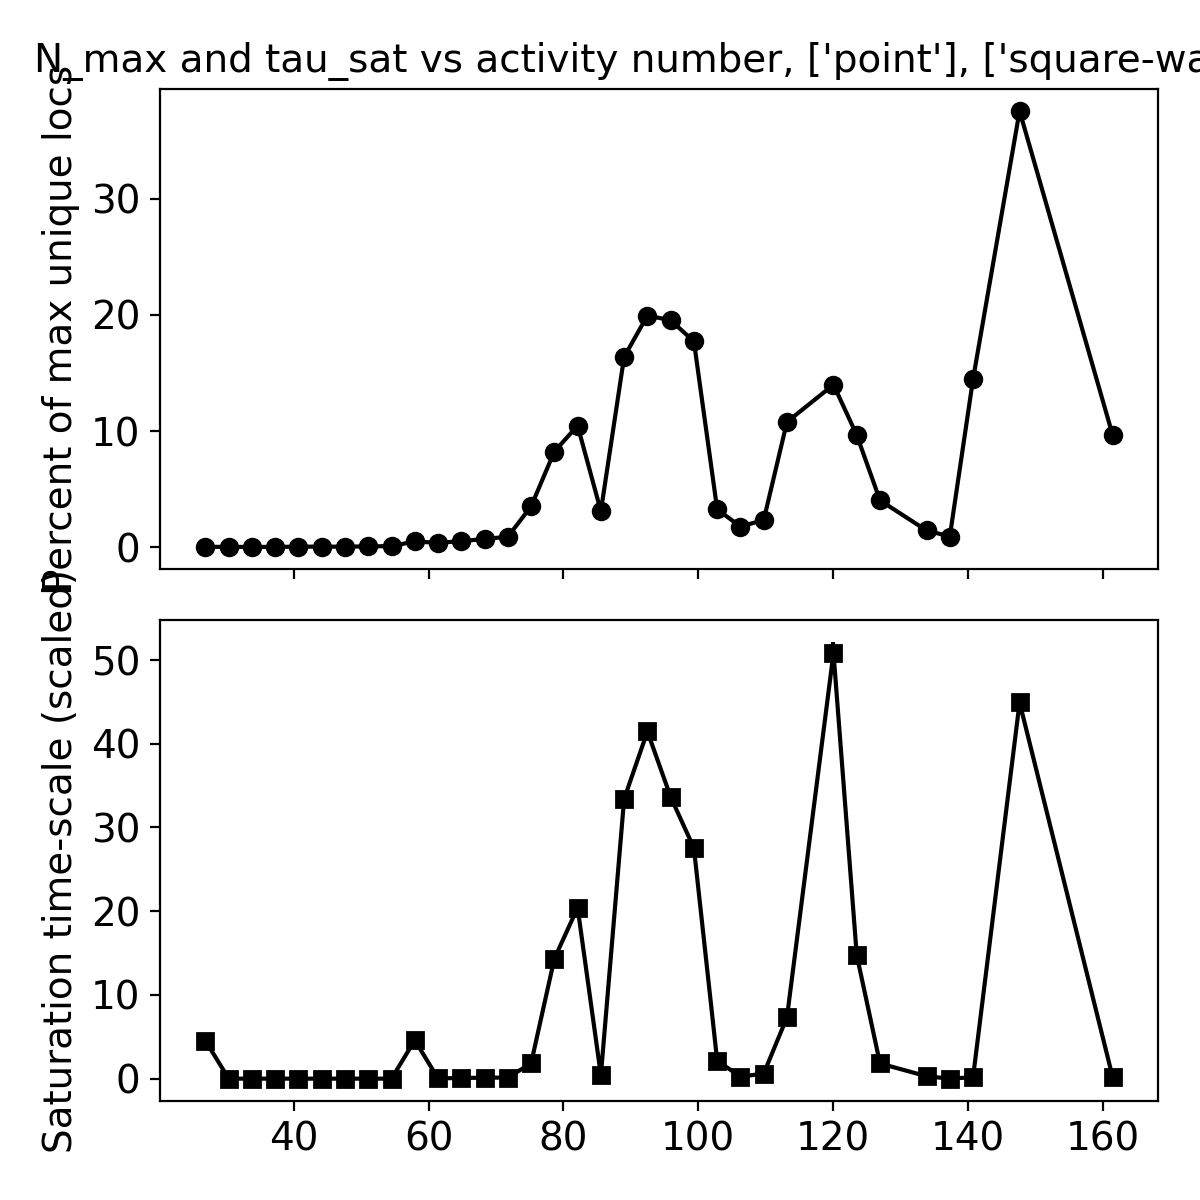

In [111]:
parameter = 'activity number'

save_fig = False

fig, (ax0, ax1) = plt.subplots(nrows = 2, ncols = 1, sharex=True, figsize = (6,6))

n_max = df_unique_locs_fit['Saturation value fit']
n_max_sigma = df_unique_locs_fit['Saturation value sigma']

tau_sat_fit = df_unique_locs_fit['Saturation time fit (rescaled)']
tau_sat_sigma = df_unique_locs_fit['Saturation time sigma (rescaled)']

x_data = df_unique_locs_fit[parameter]

ax0.errorbar(x_data, n_max, yerr=n_max_sigma, marker = 'o', color = 'k')
ax0.set_ylabel('Percent of max unique locs')

ax1.errorbar(x_data, tau_sat_fit, yerr=tau_sat_sigma, marker = 's', color = 'k')
ax1.set_ylabel('Saturation time-scale (scaled)')

title = 'N_max and tau_sat vs {}, {}, {}'.format(parameter, sim_type, activity_type)

ax0.set_title(title)
plt.tight_layout()

if save_fig:

    plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)

plt.show()

<IPython.core.display.Javascript object>


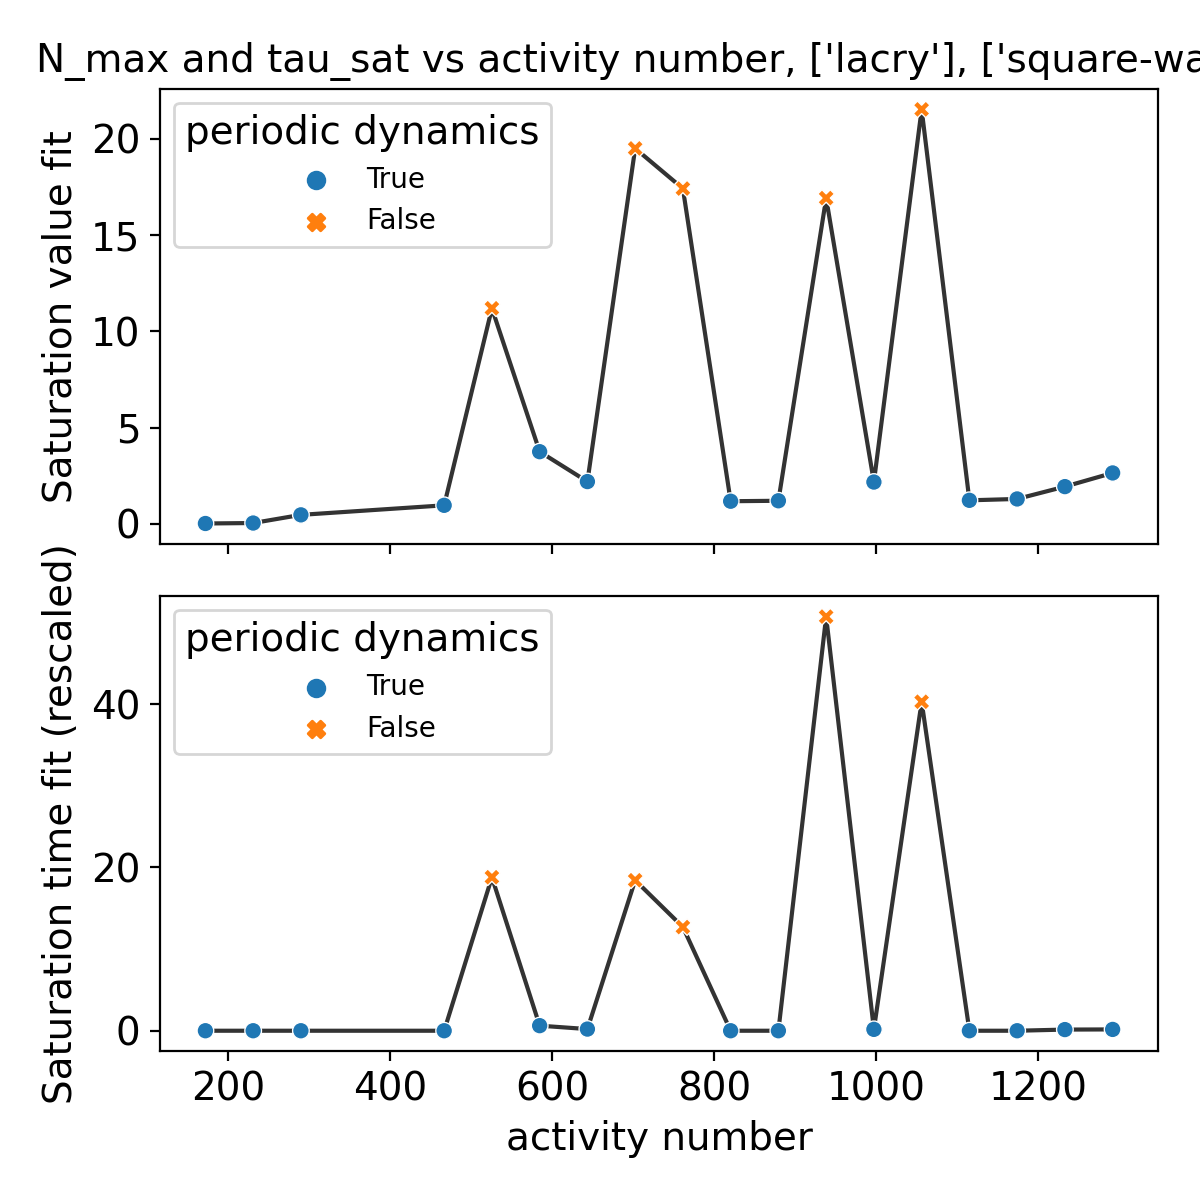

In [146]:
parameter = 'activity number'
save_fig = True
markers = {True: 'o', False:'X'}

fig, (ax0, ax1) = plt.subplots(nrows = 2, ncols = 1, sharex=True, figsize = (6,6))

n_max = df_unique_locs_fit['Saturation value fit']
n_max_sigma = df_unique_locs_fit['Saturation value sigma']

tau_sat_fit = df_unique_locs_fit['Saturation time fit (rescaled)']
tau_sat_sigma = df_unique_locs_fit['Saturation time sigma (rescaled)']

x_data = df_unique_locs_fit[parameter]


sns.lineplot(data=df_unique_locs_fit, x= parameter, y = 'Saturation value fit', style=" activity time scale", 
             markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', 
             color = 'k', alpha =0.8, legend = False, ax = ax0, zorder= 0)

sns.scatterplot(data=df_unique_locs_fit, x= parameter, y = 'Saturation value fit', style="periodic dynamics", 
                hue = 'periodic dynamics', ax = ax0, hue_order = [True, False], markers= markers, zorder = 1)

sns.lineplot(data=df_unique_locs_fit, x= parameter, y = 'Saturation time fit (rescaled)', style=" activity time scale", 
             markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', 
             color = 'k', alpha =0.8, legend = False, ax = ax1, zorder = 0)

sns.scatterplot(data=df_unique_locs_fit, x= parameter, y = 'Saturation time fit (rescaled)', style="periodic dynamics", 
                hue = 'periodic dynamics', ax = ax1, hue_order = [True, False], markers= markers, zorder = 1)

title = 'N_max and tau_sat vs {}, {}, {}'.format(parameter, sim_type, activity_type)

ax0.set_title(title)
plt.tight_layout()

if save_fig:

    plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)

plt.show()

In [84]:
# Plot the subset of data that shows some significant tip excursions
df_unique_locs_fit = df_unique_locs_fit.loc[df_unique_locs_fit[parameter]>250]

In [130]:
df_unique_locs_fit_aperiodic = df_unique_locs_fit.loc[df_unique_locs_fit['periodic dynamics']==False]

<IPython.core.display.Javascript object>


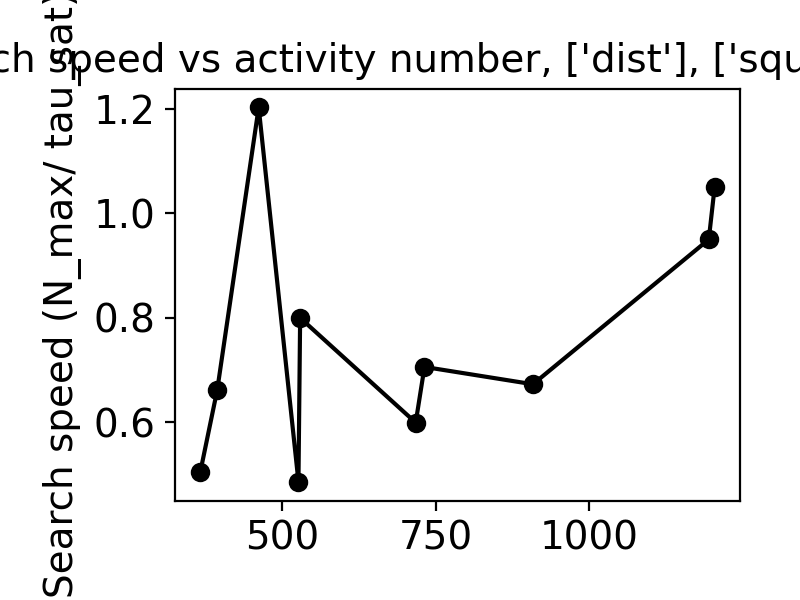

In [131]:
# Search speed plot 

save_fig = False

fig, (ax0) = plt.subplots(nrows = 1, ncols = 1, sharex=True, figsize = (4,3))

x_data = df_unique_locs_fit_aperiodic[parameter]
y_data = df_unique_locs_fit_aperiodic['Search speed']

ax0.plot(x_data, y_data, marker = 'o', color = 'k')
ax0.set_ylabel('Search speed (N_max/ tau_sat)')

title = 'Search speed vs {}, {}, {}'.format(parameter, sim_type, activity_type)

ax0.set_title(title)
plt.tight_layout()

if save_fig:

    plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)

plt.show()